# HSE-2024 text classification project

## Table of content
* [Imports](#c1)
* [Data loading and preprocessing](#c2)
* [Custom dataset](#c3)
* [Custom model](#c4)
* [Trainer](#c5)
* [Model training](#c6)

### Imports <a class="anchor" id="c1"></a>

In [1]:
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split

import os
import re
import string

from classes import Preprocessor, MyModel, Trainer

### Data loading and preprocessing <a class="anchor" id="c2"></a>

In [2]:
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

In [3]:
base_dir = 'data/'
if not os.path.exists(base_dir):  # создадим папку, куда будем сохранять модели, и где будут лежать данные
    os.makedirs(base_dir)

In [4]:
texts = pd.read_csv(f'{base_dir}texts_and_metadata.txt', sep='\t')
texts.sample(3)

,document.id,source,stage,source_text,lemm_text,city,region,date
11474,983823112,iqbuzz,3,"<b>коряк</b> жесткий, смотреть всем))) <a href...",коряк жёсткий смотреть hollaback girl this my ...,Якутск,Саха /Якутия/,2015-08-01
11886,1029357790,iqbuzz,3,А русский язык и русская культура как обьединя...,русский язык русский культура обьединять ранни...,Москва,Москва,2015-09-17
2764,1109872488,iqbuzz,2,barmalei писал(а): Это нужно спросить у местны...,re флудильнуть barmalei писать нужно спросить ...,NaN,NaN,2015-02-08


In [5]:
data = pd.read_csv(f'{base_dir}coding_results.txt', low_memory=False, sep='\t')
data.sample(3)

,document.id,source,stage,data,assessor,seed_eth_group,for_questions_about_text,do_text_make_sense_raw,do_text_make_sense_recoded,has_ethnonym_raw,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
65099,580482676,iqbuzz,2,2016-10-14 13:06:51,Tankly,карачаевец,0,yes,1,several,...,2.0,unk,3.0,irrel,3.0,irrel,1.0,no,"'Другое' = 'шапсуги', 'калаши', 'курейшиты', '...",карачаевский_57
78810,750751530,iqbuzz,2,2016-10-14 17:38:13,Tankly,уйгур,0,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,уйгур_137
48362,1032712556,iqbuzz,3,2017-04-02 14:42:29,adzhigitova,аварец,1,yes,1,several,...,2.0,unk,3.0,irrel,3.0,irrel,1.0,no,NaN,1032712556


In [6]:
df = texts.merge(data, how='left')
df.sample(5)

,document.id,source,stage,source_text,lemm_text,city,region,date,data,assessor,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
76824,1106747861,iqbuzz,3,На небе засияло ВИФЛЕЕМСКАЯ ЗВЕЗДА и главный м...,небо засиять вифлеемский звезда главный мудрец...,Москва,Москва,2015-11-27,2017-04-02 02:15:21,skuchilina,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,Другой: булгары,1106747861
23054,882980196,iqbuzz,2,У К. Бальмонта наверное стих про других русски...,бальмонт наверное стихнуть про другой этот сти...,NaN,NaN,2015-05-01,2016-10-13 20:41:17,Tankly,...,2.0,unk,3.0,irrel,3.0,irrel,1.0,no,NaN,русич_120
18568,1073645535,iqbuzz,2,"Цитата(Kuzja @ 28.10.2015, 18:01) Ко мне подкр...",re осенний зов цитата kuzja подкрадываться бол...,NaN,NaN,2015-10-28,2016-10-09 23:49:46,an_men,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,мариец_8
40145,700084544,iqbuzz,3,Стойбище народа <b>Саамы</b>: <b><font color=\...,стойбище народ саам шикарный уха олень катание...,Санкт-Петербург,Санкт-Петербург,2015-01-08,2017-03-17 10:26:24,DariaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,700084544
46688,754363727,iqbuzz,3,14 марта на вечеринку в дворянском стиле (бал-...,март вечеринка дворянский стиль нужный цыган д...,Москва,Москва,2015-02-10,2017-03-28 19:09:27,DariaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,754363727


In [7]:
df.shape

(84784, 61)

In [8]:
df['do_text_make_sense_raw'].value_counts()

do_text_make_sense_raw
yes     78372
no       4334
lang     1890
joke      188
Name: count, dtype: int64

In [9]:
df.drop(df[df['do_text_make_sense_raw'] == 'no'].index, inplace=True)

In [10]:
ops = ['is_text_positive_recoded', 'is_text_neg_recoded']
df[ops] = df[ops].apply(pd.to_numeric, errors='coerce')
pos_ = df['is_text_positive_recoded']
neg_ = df['is_text_neg_recoded']
df.loc[(pos_ > 0) & (neg_ < 0), ops] = None
df.loc[neg_ < 0, 'text_sentiment'] = -1
df.loc[pos_ > 0, 'text_sentiment'] = 1
df.loc[(neg_ == 0) & (pos_ == 0), 'text_sentiment'] = 0

In [11]:
args = ['text_sentiment', 'has_eth_conflict_raw', 'has_pos_eth_interaction_raw', 'opinion_about_ethnonym_recoded',
        'is_ethicity_superior_meaning', 'is_ethicity_aggressor_meaning',
        'is_ethicity_dangerous_meaning']
MAX_SPOIL = len(args)
topic_to_russian = {'culture': 'культура', 'economics': 'экономика', 'ethicity': 'этничность', 'history': 'история',
                    'humour': 'юмор', 'daily_routine': 'рутина', 'migration': 'миграция', 'other': 'другая',
                    'politics': 'политика', 'religion': 'религия', 'society_social': 'социальная'}
MAX_SPOIL

7

In [12]:
df['has_pos_eth_interaction_raw'].value_counts()

has_pos_eth_interaction_raw
no     62783
yes    13603
unk     1986
Name: count, dtype: int64

In [13]:
var_vocab = {
    'text_sentiment': {'labels': {-1.0: 'этот текст является негативным', 0: 'этот текст является нейтральным',
                                  1.0: 'этот текст является позитивным'}, 'aspect_level': False, 'prompt': 'тональность текста'},
    'has_eth_conflict_raw': {
        'labels': {'yes': 'в тексте есть этнический конфликт', 'no': 'в тексте этнический конфликт отсутствует',
                   'unk': None},
        'aspect_level': False, 'prompt': 'оцени наличие этнического конфликта'},
    'has_pos_eth_interaction_raw': {'labels': {'yes': 'в тексте есть позитивное взаимодействие между этичностями',
                                               'no': 'в тексте не зафиксировано позитивного взаимодействия этичностей',
                                               'unk': None},
                                    'aspect_level': False, 'prompt': 'наличие позитивного взаимодействия этничностей'},
    'opinion_about_ethnonym_recoded': {'labels': {-1: 'мнение об этничности \'{}\' отрицательное',
                                                  0: 'мнение об этничности \'{}\' нейтральное или не зафиксировано',
                                                  1: 'мнение об этничности \'{}\' положительное'},
                                       'aspect_level': True, 'prompt': 'мнение о {} в тексте'},
    # 'represent_ethicity_meaning': {'labels': {}, 'aspect_level': True}, # not using yet
    'is_ethicity_superior_meaning': {'labels': {'high': 'этничность \'{}\' является доминирующей',
                                                'low': 'этничность \'{}\' является отчасти доминирующей',
                                                'irrel': None},
                                     'aspect_level': True, 'prompt': 'является ли этничность {} доминирующей'},
    'is_ethicity_aggressor_meaning': {'labels': {'agressor':
                                                     'этничность \'{}\' является агрессором',
                                                 'victim': 'этничность \'{}\' является жертвой',
                                                 'irrel': None},
                                      'aspect_level': True, 'prompt': 'является ли этничность {} агрессором'},
    'is_ethicity_dangerous_meaning': {
        'labels': {'yes': 'этничность \'{}\' является опасной',
                   'no': 'этничность \'{}\' не является опасной',
                   'irrel': None},
        'aspect_level': True, 'prompt': 'является ли этничность {} опасной'},
}

In [14]:
df = df.fillna(np.nan).replace([np.nan], [None])

In [15]:
ids = df['document.id'].unique()
ids.shape  # 14196 после дропа по do_text_make_sence = no

(14196,)

In [16]:
def clean(text):
    text = text.apply(lambda x: str(x))
    CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]
    for i in CLEANR:
        text = text.apply(lambda x: re.sub(i, '', x))
    text = text.apply(lambda x: x.replace('\\', ''))
    text = text.apply(lambda x: re.sub(r"([" + re.escape(string.punctuation) + r"])\1+", r"\1", x))
    text = text.apply(lambda x: re.sub(r"http\S+", '', x))
    text = text.apply(lambda x: re.sub(r"\r", '', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub('"+','"', x))
    text = text.apply(lambda x: re.sub("'+","'", x))
    items = string.punctuation + " "
    text = text.apply(lambda x: x.lstrip(items) if isinstance(x, str) else x)
    return text

<>:3: SyntaxWarning: invalid escape sequence '\['
<>:3: SyntaxWarning: invalid escape sequence '\['
C:\Users\bentodan\AppData\Local\Temp\ipykernel_11952\3087058704.py:3: SyntaxWarning: invalid escape sequence '\['
  CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]


In [17]:
df['source_text'] = clean(df['source_text'])

In [18]:
df['source_text'][0]

'но у вас же бред написан. Какими русскими? Вообще то там грузины воевали с Абхазами. Это исторический факт. А статья может быть на 10% правдива. Почему вы верите, какой-то статье?'

In [19]:
preprocessor = Preprocessor.Preprocessor(df=df, args=args, var_vocab=var_vocab, topic_to_russian=topic_to_russian)

In [20]:
id_ = df['document.id'].sample().values[0]
descr, text = preprocessor.fit(id_)
print(id_, descr, text, sep='\n')

278590
в тексте этнический конфликт отсутствует, в тексте не зафиксировано позитивного взаимодействия этичностей

News | Футболисты «Анжи» — в национальной и молодёжной сборных РоссииТренерский штаб сборной России определился с окончательным списком из 25 футболистов, которые будут готовиться к матчу отборочного турнира чемпионата мира 2014 года против Северной Ирландии (22 марта) и товарищеской игре с бразильцами (25 марта).В этом списке 5 футболистов «Анжи»: Владимир Габулов, Андрей Ещенко, Арсений Логашов, Юрий Жирков, Олег Шатов.Тем временем форвард «Анжи» Фёдор Смолов приглашен в молодёжную сборную России, которая будет готовиться к ближайшим товарищеским матчам. 22 марта россияне сыграют с молодёжной сборной Италии, а 25 марта — с молодёжной сборной Испании.#Анжи #Anj


In [21]:
descr_spoiled, text = preprocessor.fit(id_, spoil_size=len(preprocessor.args))
print(descr, descr_spoiled, sep='\n')

в тексте этнический конфликт отсутствует, в тексте не зафиксировано позитивного взаимодействия этичностей

в тексте есть этнический конфликт



In [22]:
descr_topics, _ = preprocessor.fit(id_, topic=True)
descr_topics_spoiled, _ = preprocessor.fit(id_, topic=True, topic_spoil=1)
print(descr_topics, descr_topics_spoiled, sep='\n')

в тексте этнический конфликт отсутствует, в тексте не зафиксировано позитивного взаимодействия этичностей

в тексте этнический конфликт отсутствует, в тексте не зафиксировано позитивного взаимодействия этичностей



### Custom dataset <a class="anchor" id="c3"></a>

In [23]:
process_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=RANDOM_STATE)
train_ids, validate_ids = train_test_split(process_ids, train_size=0.75, random_state=RANDOM_STATE)

train = df.loc[df['document.id'].isin(train_ids)]
test = df.loc[df['document.id'].isin(test_ids)]
validate = df.loc[df['document.id'].isin(validate_ids)]
train.shape, test.shape, validate.shape  # percents are ≈ (60%, 20%, 20%)

((47999, 62), (16170, 62), (16281, 62))

### Custom model <a class="anchor" id="c4"></a>

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device used: {device}.")

Device used: cpu.


In [25]:
model = MyModel.MyModel(device) # turn on the developer mode here
print(f"Model loaded. Model tokenizer is {model.tokenizer}.")

Model loaded. Model tokenizer is BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}.


In [26]:
model.reinitialize()
print(f"Model reloaded. Model tokenizer is {model.tokenizer}.")

Model reloaded. Model tokenizer is BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}.


### Trainer <a class="anchor" id="c5"></a>

In [27]:
params = {
    'batch_size': [8, 16],
    'lr': [1e-5, 1e-6, 1e-4],
    'max_spoil': range(1, MAX_SPOIL + 1, 2),
    'spoil_proba': np.arange(0.2,  0.8 + 0.1, 0.1)
}

In [28]:
trainer = Trainer.Trainer(MyModel.MyModel, device, train, validate, test, preprocessor=preprocessor, params=params)

### Model training <a class="anchor" id="c6"></a>

In [29]:
torch.cuda.empty_cache()  # just in case

In [30]:
# trainer.choose_model()

In [31]:
# trainer.save()

In [32]:
# trainer.train(epochs=2)

In [33]:
# trainer.plot_loss(on_train=False)

In [34]:
# trainer.plot_metrics(on_train=False)

### Генерация описаний

In [35]:
from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):

    def __init__(self, df, preprocessor, args, id_column='document.id', topic=False, num=None, fixed=True):
        """
        :param df: input data in DataFrame format
        :param preprocessor: class to generate prompt and decription
        :param id_column: column to set index on (default is None)
        :param args: args to consider
        :param topic: if True topics will be included in the decription
        :param num: number of args to include in prompt, if None, all will be included
        :param fixed: if False, args will be choosen on each iteration
        """

        self.df = df.copy()

        if id_column:
            self.id_col = id_column
            self.df.set_index(id_column, inplace=True)

        self.topic = topic
        self.preprocessor = preprocessor
        self.unique_ids = self.df.index.unique()
        self.args=args
        self.num = min(num or 0, len(args))
        self.fixed = fixed
        self.fixed_args = None

        if num and num > 0 and fixed:
            self.fixed_args = np.random.choise(self.args, size=num, replace=False)
        
    def __len__(self):
        """
        :return: length of the dataset
        """
        return len(self.unique_ids)

    def __getitem__(self, idx):
        """
        :param idx: index of the sample to be returned
        :return: prompt
        """
        id_ = self.unique_ids[idx]

        if self.num > 0 and not self.fixed:
            self.fixed_args = np.random.choise(self.args, size=self.num, replace=False)

        prompt, description, text = self.preprocessor.fit(id_=id_, topic=self.topic, topic_spoil=0, spoil_size=0, prompt=True, prompt_list=self.fixed_args)

        return f'Задание: {prompt or ""}\nТекст: {text or ""}\nОписание: {description or ""}',  f'Задание: {prompt or ""}\nТекст: {text or ""}\nОписание:'

In [36]:
gptdataset = GPTDataset(df, preprocessor=preprocessor, args=var_vocab)
gptloader = DataLoader(gptdataset, batch_size=5, shuffle=True)

In [37]:
print(gptdataset[0][0]), print(gptdataset[0][1])

Задание: Сгенерируй описание следующего текста, оценитональность текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность абхаз доминирующей, является ли этничность абхаз агрессором, является ли этничность абхаз опасной.
Текст: но у вас же бред написан. Какими русскими? Вообще то там грузины воевали с Абхазами. Это исторический факт. А статья может быть на 10% правдива. Почему вы верите, какой-то статье?
Описание: этот текст является негативным, в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей

Задание: Сгенерируй описание следующего текста, оценитональность текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность абхаз доминирующей, является ли этничность абхаз агрессором, является ли этничность абхаз опасной.
Текст: но у вас же бред написан. Какими русскими? Вообще то т

(None, None)

In [51]:
from torch import nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel

class GPTModel(nn.Module):
    """Pretrained model with custom text classificator."""

    def __init__(self, device, max_len=512, max_len_model=100, ngram=2, pretrained_model_path="ai-forever/rugpt3small_based_on_gpt2"):
        """
        :param device: device to use
        :param max_len: maximal length for Tokenizer
        :param pretrained_model_path: model to load for fine-tuning
        """
        super().__init__()
        try:
            self.model = GPT2LMHeadModel.from_pretrained(pretrained_model_path)
            self.tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_path, model_max_length=max_len)
        except OSError:
            print("Could not load pretrained model")
        self.device = device
        self.max_len = max_len
        self.max_len_model = max_len_model
        self.path = pretrained_model_path
        self.ngram = ngram

    def reinitialize(self, ngrams):
        """
        Reloads model and tokenizer
        """
        try:
            self.model = GPT2LMHeadModel.from_pretrained(self.path)
            self.tokenizer = GPT2Tokenizer.from_pretrained(self.path, model_max_length=self.max_len)
        except OSError:
            print("Could not load pretrained model")

        self.ngram = ngrams

    def generate(self, sentence):
        sentence_enc = self.tokenizer.encode(sentence, return_tensors='pt') 
        output = self.model.generate(sentence_enc, max_new_tokens=self.max_len_model, num_beams=2, no_repeat_ngram_size=self.ngram, early_stopping=True)
        if output[0] is not None:
            return self.tokenizer.decode(output[0], skip_special_tokens=True)

    def forward(self, x, y):
        """
        :param x: input text
        :param y: text with description cut
        :return: tensor of output data
        """
        
        tokenized = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt").to(self.device)  # токенизируем
        tokenized_nodesc = self.tokenizer(y, padding=True, truncation=True, return_tensors="pt").to(self.device)
    
        input_ids = tokenized['input_ids']
        input_ids_nodesc = tokenized['input_ids']
           
        for i in range(input_ids.size(0)):
            input_ids[i][:len(input_ids_nodesc[i])] = self.tokenizer.pad_token_id
    
        return self.model(**tokenized, labels=input_ids)

In [52]:
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchtext.data.metrics import bleu_score 

from itertools import product
from IPython.display import clear_output

import numpy as np

import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader


class GPTTrainer:
    """Class for model training and validation."""

    def __init__(self, model, device, train, validate, test, dataset, args, dataloader,
                 save=True,
                 params=None,
                 preprocessor=None,
                 optimizer=torch.optim.Adam, batch_size=10,
                 base_dir='data/',
                 best_model_path='best_model',
                 train_window_size=10,
                 test_window_size=5,
                 max_len=512,
                 epochs=10, number_of_generations=10,
                 learning_rate=0.0005, metric_to_use='bleu_score', min_spoil=1, timer=1):
        """
        :param model: model to train
        :param device: device used for model training
        :param train: train data
        :param validate: validation data
        :param test: test data
        :param params: grid of hyperparams for best model selection
        :param dataset: dataset derived from torch.utils.data.Dataset
        :param args: args for dataset (structure specifical) 
        :param dataloader: dataloader derived from torch.utils.data.DataLoader
        :param save: if True, model will be saved each epoch
        :param preprocessor: preprocessor to pass to dataset 
        :param optimizer: optimizer to use
        :param base_dir: base directory to save data to
        :param best_model_path: best model will be saved at f'{base_dir}{best_model_tpath}'
        :param train_window_size: number of train batches for average score calculation
        :param train_window_size: number of test batches for average score calculation
        :param max_len: maximal length for Tokenizer
        :param epochs: number of epochs for model training
        :param learning_rate: learning rate
        :param metric_to_use: which metric should be considered for best model choosing
        """

        try:
            self.model = model(device, max_len=max_len).to(device)
        except OSError:
            print("Could not load model to device")

        self.preprocessor = preprocessor
        self.train_dataset = dataset(train.copy(), args=args, preprocessor=preprocessor)
        self.test_dataset = dataset(test.copy(), args=args, preprocessor=preprocessor)
        self.dataloader = dataloader
        self.args = args

        self.max_len = max_len

        try:
            self.train_loader = dataloader(self.train_dataset, batch_size=batch_size)
            self.test_loader = dataloader(self.test_dataset, batch_size=batch_size)
        except OSError:
            print("Could not load dataset")

        if metric_to_use not in ['bleu_score']:
            raise ValueError("metric_to use must be one of 'bleu_score'")

        self.train_ = train
        self.test_ = test
        self.validate = validate

        self.device = device
        self.lr = learning_rate
        self.batch_size = batch_size
        self.base_dir = base_dir
        self.best_model_path = best_model_path
        self.train_window_size = train_window_size
        self.test_window_size = test_window_size
        self.min_spoil = min_spoil
        self.timer = timer

        self.save = save

        self.opt = optimizer
        self.optimizer = optimizer(self.model.parameters(), lr=learning_rate)
        self.metric_to_use = metric_to_use
        self.best_metric = -float('inf')

        self.epochs = epochs
        self.params = params
        self.num = 0

        self.number_of_gen = number_of_generations
        self.ids = np.random.choice(range(len(self.test_loader)), size=min(number_of_generations, len(self.test_loader)), replace=False)

        self.data = dict()


    def reinitialize(self, batch_size, lr, ngrams):
        self.model.reinitialize(ngrams)
        self.model.to(self.device)

        self.train_loader = self.dataloader(self.train_dataset, batch_size=batch_size)
        self.test_loader = self.dataloader(self.test_dataset, batch_size=batch_size)

        self.optimizer = self.opt(self.model.parameters(), lr=lr)

    def choose_model(self):
        for val in product(*self.params.values()):
            params = {k: v for k, v in zip(self.params, val)}
            self.reinitialize(**params)
            self.data[self.num] = dict()
            self.data[self.num]['params'] = params
            self.train(self.epochs)
            self.num += 1

    def train_one_epoch(self, epoch, verbose=False):

        cur_loss = sum_loss = 0

        for i, (data, cut_data) in enumerate(tqdm(self.train_loader), 1):
            self.optimizer.zero_grad()
            outputs = self.model(data, cut_data)
            loss = outputs.loss
            loss.backward()
            self.optimizer.step()
            loss_ = loss.item()

            if self.num not in self.data:
                self.data[self.num] = dict()

            if 'train_loss' not in self.data[self.num]:
                self.data[self.num]['train_loss'] = []

            self.data[self.num]['train_loss'].append(loss_)
            cur_loss += loss_

            if i % self.train_window_size == 0:
                last_loss = cur_loss / self.train_window_size
                sum_loss += last_loss
                cur_loss = 0
                if verbose:
                    print(f"batch {i}\nloss: {last_loss:.5}")
                    
        return sum_loss / len(self.train_loader)

    def validate_one_epoch(self, epoch, verbose=False):
        sum_loss = 0

        with torch.no_grad():
            for i, (data, cut_data) in enumerate(tqdm(self.test_loader), 1):
                outputs = self.model(data, cut_data)
                loss_ = outputs.loss.item()

                if self.num not in self.data:
                    self.data[self.num] = dict()

                if 'test_loss' not in self.data[self.num]:
                    self.data[self.num]['test_loss'] = []

                self.data[self.num]['test_loss'].append(loss_)
                sum_loss += loss_

                if verbose and i % self.test_window_size == 0:
                    print(f"Batch {i} validation")

        for id_ in self.ids:
            if epoch not in self.data[self.num]:
                self.data[self.num][epoch] = {}
            if 'generated' not in self.data[self.num][epoch]:
                self.data[self.num][epoch]['generated'] = []
            
            self.data[self.num][epoch]['generated'].append((id_, self.model.generate(self.test_dataset[id_]))) # добавляем id и сгенерированное описание

        if verbose:
            print(f"Calculating epoch {epoch + 1} validation scores")

        return sum_loss / len(self.train_loader)

    def train(self, epochs, verbose=False, plot=True, save=False):
        for epoch in range(epochs):

            if verbose:
                time = datetime.now()
                print(f"Epoch {epoch + 1} running")

            self.model.train(True)
            loss = self.train_one_epoch(epoch, verbose=verbose)

            if plot:
                clear_output(wait=True)
                self.plot_loss(on_train=True)
            
            self.model.eval()
            v_loss = self.validate_one_epoch(epoch, verbose=verbose)

            if plot:
                clear_output(wait=True)
                self.plot_loss(on_train=False)

            if verbose:
                print(f'Time taken for epoch {epoch + 1}: {datetime.now() - time}\n')

            if save or self.save:
                self.save_model(v_loss, epoch, verbose)

    def save_model(self, metric, epoch, verbose):
        path = f'{self.base_dir}/epoch_{epoch}_num_{self.num}_loss_{metric}'
        torch.save(self.model.state_dict(), path)

    def load_model(self, model_path):
        model = MyModel(self.device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        return model

    def plot_loss(self, on_train=False):
        if on_train:

            data = self.data[self.num]['train_loss']

            plt.plot(data)
            plt.title('Training loss')

            step = len(self.train_loader)
            for el in range(step, len(data), step):
                plt.axvline(x=el, color='red', linestyle='--')
        else:

            data = self.data[self.num]['test_loss']

            plt.plot(data)
            plt.title('Validation loss')

            step = len(self.test_loader)
            for el in range(step, len(data), step):
                plt.axvline(x=el, color='red', linestyle='--')

        plt.xlabel('Batches')
        plt.ylabel('Loss')
        plt.show()

    def save(self):
        with open(f'{self.base_dir}/data.pkl', 'wb') as f:
            pickle.dump(self.data, f)


In [53]:
max_items = 200
gptTrainer = GPTTrainer(GPTModel, device, train[:max_items], validate[:max_items], test[:max_items], preprocessor=preprocessor, dataset=GPTDataset, args=var_vocab, dataloader=DataLoader)

In [54]:
print(gptTrainer.model.generate('Что такое питон?')) # слон - это змея:)

Что такое питон?
Питон - это млекопитающее, которое питается плодами растений и животных.

Какие у вас ассоциации со словом "питон"?
Птица
птица, которая летает, летающая, летящая
Это птица. Птица - птица, которую можно увидеть в небе, а можно и не увидеть. Это птица-попугай, который живет на земле. А еще это птица - птичка, которой можно летать. И еще - птеродактиль


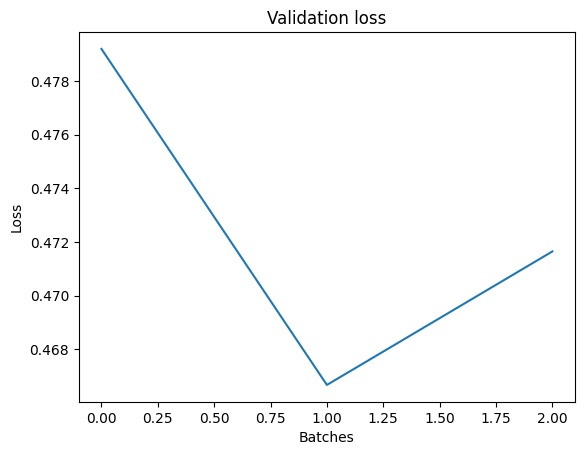

In [55]:
gptTrainer.train(1)

In [56]:
print(gptTrainer.model.generate('Что такое питон?'))

Что такое питон? Стрель силовых меня Бо Ни З Нет Г Ничего� Есть Господи том Какие Правда и пред Л Из б Точно m На Ф Изви 1 [ него только ст Зна те Понятно Ш Прошу них Ск Хо Мой При Слушай что Конечно Она� Для по


In [57]:
for el in gptTrainer.data[0][0]['generated']:
    print(el[1])
    break

 меня Бо З Ни Г Нет Ничего Есть� том На Господи Правда Из пред Какие и Ф Л [ б него m Точно Зна ст 1 только Понятно что них Изви Прошу Ш Хо те Мой Слушай Ск Ва� При по Для Пу Пусть
